## **Bank churn prediction** 

Aims: Build a prediction model that will perform the following: Classify if a customer is going to churn or not
Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

In [71]:
# Importing project dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### **----------------------------------  1. Data collection  -----------------------------------**

In [72]:
# Importing data through API 
!kaggle datasets download -d kmalit/bank-customer-churn-prediction -p ..\Data --unzip 

404 - Not Found


In [73]:
# Loading data into dataframe 
data = pd.read_csv('../Data/Churn_Modelling.csv')

#### **----------------------------------  2. Data pre-processing  -----------------------------------**

In [74]:
# Viewing dataset shape
data.shape

(10000, 14)

In [75]:
# Unique count for each variable
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [76]:
# Check variable data types
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [77]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [78]:
# 2nd check for number of null values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [79]:
data.isna().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [80]:
# Dropping columns that arent needed 
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [81]:
# removing potential capital letters and spaces in column headers
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ','_')

In [82]:
# Viewing first 5 rows of dataframe
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### **----------------------------------  3. Exploratory data analysis  -----------------------------------**

In [83]:
amount_retained = data[data['exited'] == 0]['exited'].count() / data.shape[0] * 100
amount_lost = data[data['exited'] == 1]['exited'].count() / data.shape[0] * 100

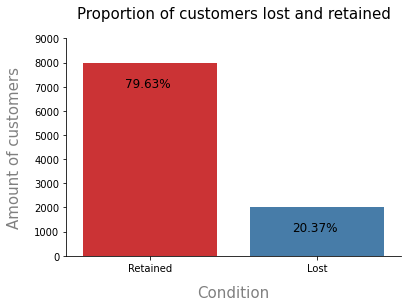

In [84]:
fig, ax = plt.subplots()
sns.countplot(x='exited', palette="Set1", data=data)
plt.xticks([0, 1], ['Retained', 'Lost'])
plt.xlabel('Condition', size=15, labelpad=12, color='grey')
plt.ylabel('Amount of customers', size=15, labelpad=12, color='grey')
plt.title("Proportion of customers lost and retained", size=15, pad=20)
plt.ylim(0, 9000)
plt.text(-0.15, 7000, f"{round(amount_retained, 2)}%", fontsize=12)
plt.text(0.85, 1000, f"{round(amount_lost, 2)}%", fontsize=12)
sns.despine()
plt.show()

<AxesSubplot:>

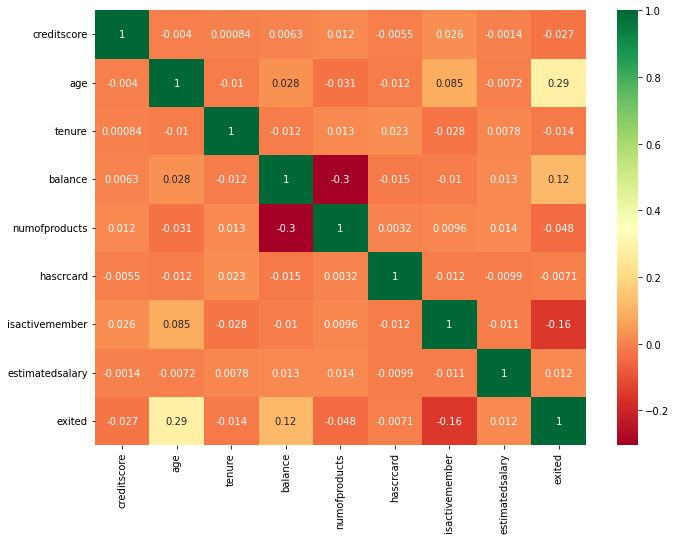

In [85]:
f, ax = plt.subplots(figsize=(11, 8)) 
sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\User

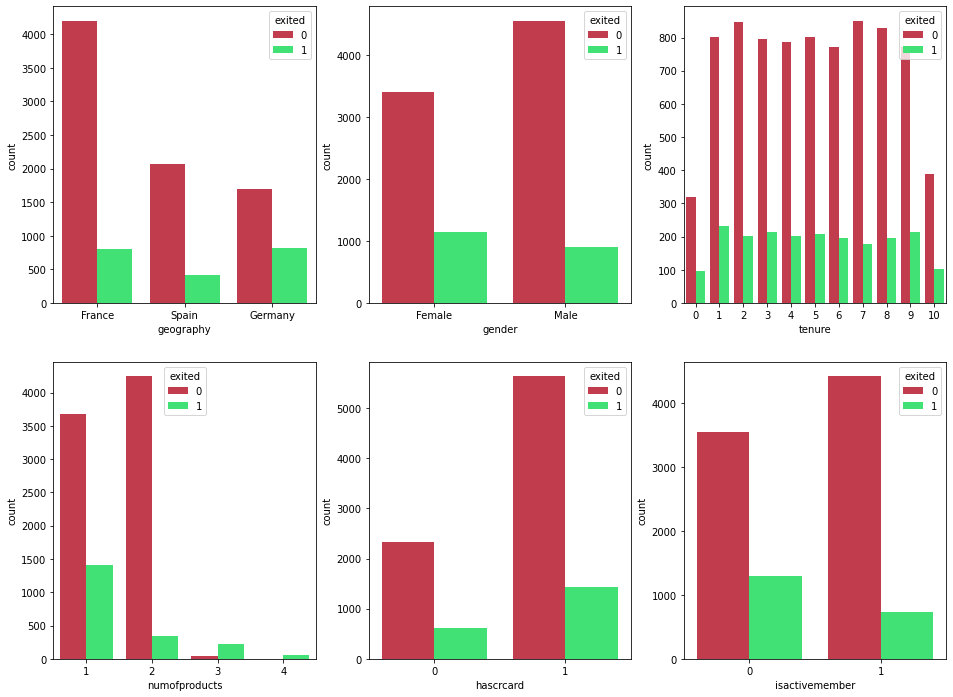

In [86]:
#Putting all the above results in a single visualization

fig_data=['geography', 'gender', 'tenure','numofproducts', 'hascrcard','isactivemember']
q=1
plt.figure(figsize=(16,12))
# Plot a grid with count plots of all categorical variables
for j in fig_data:
    plt.subplot(2,3,q)
    ax=sns.countplot(data[j],hue=data.exited, palette=['#D7263D','#27FB6B'])
    plt.xlabel(j)
    q+=1
plt.show()

In [87]:
female_churn = round(data[(data['exited'] == 1) & (data['gender'] == 'Female')]['exited'].count() / data[data['gender'] == 'Female']['exited'].count()*100, 2)
male_churn = round(data[(data['exited'] == 1) & (data['gender'] == 'Male')]['exited'].count() / data[data['gender'] == 'Male']['exited'].count() * 100, 2)

print(f"The percentage of female customers churning is {female_churn}% while the percetage of male customers churning is {male_churn}%")

The percentage of female customers churning is 25.07% while the percetage of male customers churning is 16.46%


In [88]:
active_churn = round(data[(data['exited'] == 1) & (data['isactivemember'] == 1)]['exited'].count() / data[data['isactivemember'] == 1]['exited'].count()*100, 2)
inactive_churn = round(data[(data['exited'] == 1) & (data['isactivemember'] == 0)]['exited'].count() / data[data['isactivemember'] == 0]['exited'].count() * 100, 2)

print(f"The percentage of active members churning is {active_churn}% while the percetage of inactive members churning is {inactive_churn}%")

The percentage of active members churning is 14.27% while the percetage of inactive members churning is 26.85%


In [89]:
credit_churn = round(data[(data['exited'] == 1) & (data['hascrcard'] == 1)]['exited'].count() / data[data['hascrcard'] == 1]['exited'].count()*100, 2)
no_credit_churn = round(data[(data['exited'] == 1) & (data['hascrcard'] == 0)]['exited'].count() / data[data['hascrcard'] == 0]['exited'].count() * 100, 2)

print(f"The percentage of custumers with credit card churning is {credit_churn}% while the percetage that do not have credit cards and")
print(f"churn is {no_credit_churn}%")

The percentage of custumers with credit card churning is 20.18% while the percetage that do not have credit cards and
churn is 20.81%


In [90]:
# Viewing first 5 rows of dataframe
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<AxesSubplot:xlabel='exited', ylabel='estimatedsalary'>

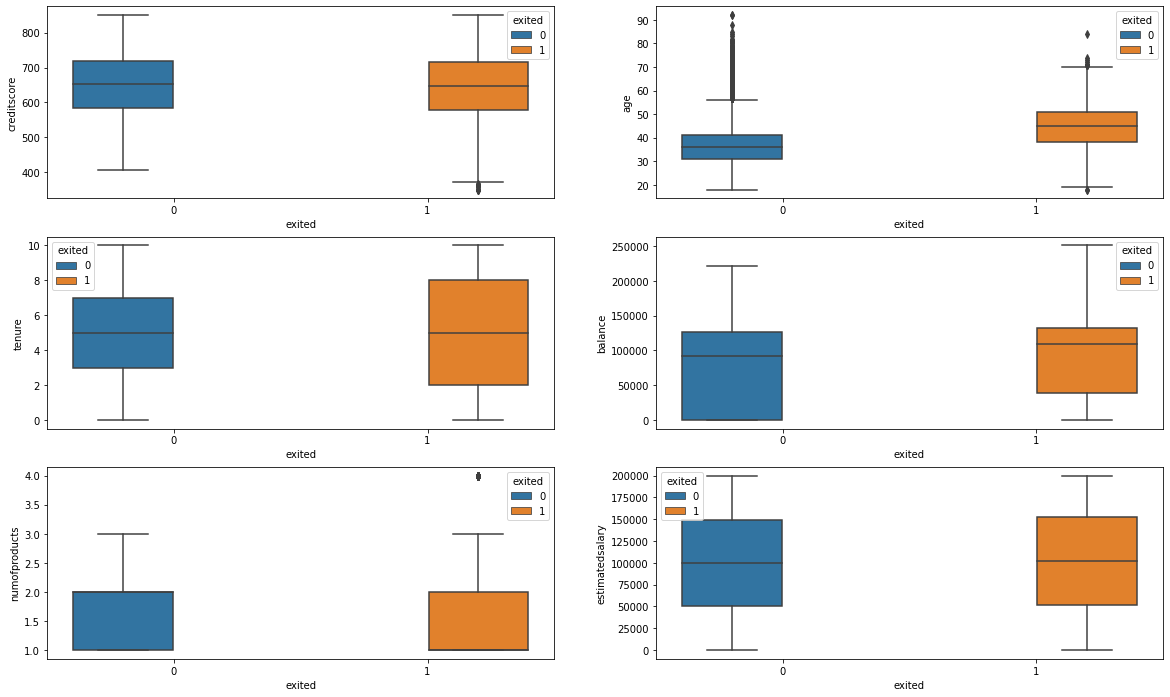

In [91]:
 # Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='creditscore',x = 'exited', hue = 'exited',data = data, ax=axarr[0][0])
sns.boxplot(y='age',x = 'exited', hue = 'exited',data = data , ax=axarr[0][1])
sns.boxplot(y='tenure',x = 'exited', hue = 'exited',data = data, ax=axarr[1][0])
sns.boxplot(y='balance',x = 'exited', hue = 'exited',data = data, ax=axarr[1][1])
sns.boxplot(y='numofproducts',x = 'exited', hue = 'exited',data = data, ax=axarr[2][0])
sns.boxplot(y='estimatedsalary',x = 'exited', hue = 'exited',data = data, ax=axarr[2][1])

#### **----------------------------------  4. Feature engineering  -----------------------------------**